# COVID19 severe (hospitalized) cases in Brazil

# Multivariate logistic regression

Publicly available data for hospitalized cases in Brazil is used to perform a retrospective cross-sectional observational study.

It means that we want to infer the paramaters driving the outcome from data gathered from hospitals.
The data has been downloaded, selected and preprocessed before the steps described in this notebook.

The aim is to compare different variants and infer what parameters are driving the severity and the outcome.<br>
I proceed as follow:
<ol>
    <li> Compute some new features from the data (time between some dates, etc) and explore data</li>
    <li> Perform univariate logistic regression</li>
            <ol><li>Perform regression</li><li>Show results</li></ol>
    <li><strong>Based on the result of the univariate regression, move to a multivariate logistic regression with stepwise approach (Presented in this notebook)</strong></li>
</ol>
    
| Features in the data | Features added | Primary Outcome (Label) | Secondary Outcome |
|-|-|-|-|
| age | age group | death/cured | ICU admission |
| sex | nber of comorbidities | | ventilation (invasive/noninvasive) |
| ethnicity | nber of vaccine doses received | | |
| Federative unit (i.e., state) | delay between last dose of vaccine (if >=2) and 1st symptoms | | |
| symptoms | length of hospital stay | | |
| comorbidities | delay between 1st symptoms and hospitalization | | |
| pregnancy status | | | |

This is applied to four different periods of time when four different variants where dominant (>=80% of samples analyzed were corresponding to the variant of interest, source: GISAID database):
- Delta
- Omicron BA.1
- Omicron BA.2
- Omicron BA.4/BA.5

> **Data source**: all the data has been taken from the Brazilian Ministry of Health https://opendatasus.saude.gov.br/organization/ministerio-da-saude
>
>It requires translation from Portuguese to English

## Python module used in this notebook

In [1]:
import pandas as pd
import scipy.stats as scst
import sys
import numpy as np
import matplotlib.pyplot as plt
import subprocess

## Parameters definition: 

- variant period of time/names
- age class
- comorbidity list in English
- ethnicity list in English

In [2]:
variants_period = [['2021-09-12','2021-12-19'],['2022-01-03','2022-03-20'],['2022-04-11','2022-05-29'],
                   ['2022-07-18','2022-10-02']]
variants_name = ['Delta','BA.1.X','BA.2.X','BA.4/5.X']
file_name = ['Delta','BA1X','BA2X','BA45X']
#age_class = [[0,4],[5,9],[10,14],[15,19],[20,29],[30,39],[40,49],[50,59],[60,64],[65,69],[70,74],[75,79],[80]]
age_range = [[0,4],[5,14],[15,24],[25,44],[45,54],[55,64],[65]]
age_code = [0,1,2,3,4,5,6]
gender = ['Female','Male']
comorb_list = ['cardiovascular_disease','hematologic_disease','down_syndrom','liver_disease','asthma','diabetes',
          'neurological_disease','chronic_lung_disease','weaken_immune_system','renal_disease','obesity','puerperal',
               'other_comorbidities']
race_list = ['Indigenous','Brown','Asian','Black','White','Unknown']
replace_label = [['age_group 0','0-4 y'],['age_group 1','5-14 y'],['age_group 2','15-24 y'],['age_group 3','25-44 y'],
                 ['age_group 4','45-54 y'],['age_group 5','55-64 y'],['age_group 6','65+ y'],['icuadm','ICU adm'],
                 ['ventilation_outoficu','Ventilation out of ICU'],
                 ['delay_vaccine','delay between last vaccine dose (2+) and 1st symp'],
                 ['90','90d'],['_',' ']]

# Multivariate logistic regression

- Load data

In [3]:
df_encoded = pd.read_parquet('encoded_severe_cases_data.pq')
df_analysis = pd.read_parquet('analysis_severe_cases_data.pq')
df_analysis.outcome = df_analysis.outcome.replace('cured',0).replace('death',1)

In [4]:
df_analysis.head()

,variant,age,age_group,sex,nb_comorbidities,cardiovascular_disease,hematologic_disease,down_syndrom,liver_disease,asthma,...,ethnicity,length_stay,length_delay,outcome,state,symptoms,icu_adm,ventilation_invasive,ventilation_noninvasive,pregnancy
0,Delta,52,4,Male,0.0,0.0,0.0,0.0,0.0,0.0,...,white,14.0,3.0,0,SP,"persistent_cough,shortness_of_breath,low_o2_sa...",1.0,0.0,1.0,NaN
1,Delta,71,6,Female,3.0,1.0,0.0,0.0,0.0,0.0,...,None,6.0,3.0,1,CE,"shortness_of_breath,low_o2_sat, loss_of_appeti...",1.0,0.0,1.0,0.0
2,Delta,80,6,Male,NaN,NaN,NaN,NaN,NaN,NaN,...,white,7.0,7.0,0,SP,"sore_throat,shortness_of_breath,low_o2_sat",0.0,0.0,1.0,NaN
3,Delta,89,6,Female,0.0,0.0,0.0,0.0,0.0,0.0,...,None,3.0,3.0,0,SP,"shortness_of_breath,low_o2_sat,diarrhoea",1.0,NaN,NaN,0.0
4,Delta,56,5,Male,0.0,0.0,0.0,0.0,0.0,0.0,...,None,7.0,9.0,0,DF,"fever,sore_throat,low_o2_sat, shortness_of_bre...",0.0,0.0,1.0,NaN


### Multivariate logistic regression per variant: primary outcome

- import modules

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from numpy.linalg import LinAlgError

- Regression results

    - Splitting parameters between parameters with reference level (categorical) and parameters without reference (continuous)
    - Add comorbidities parameter with reference

In [6]:
univariate_parameters_withref = ['state','age_group','sex','ethnicity','nb_comorbidities','nb_vaccine_dose','icuadm',
                                 'ventilation','ventilation_outoficu','invasive_ventilation','delay_vaccine']
univariate_parameters = ['length_stay','length_delay']
univariate_comorbidities = ['cardiovascular_disease','hematologic_disease','down_syndrom','liver_disease','asthma',
                            'diabetes','neurological_disease','chronic_lung_disease','weaken_immune_system',
                            'renal_disease','obesity','puerperal','other_comorbidities']
list_comorb_releveled = []
for comorb in univariate_comorbidities:
    df_analysis[comorb+'_prereleveled'] = np.where(df_analysis[comorb]==0,'No',None)
    df_analysis[comorb+'_prereleveled'] = np.where(df_analysis[comorb]==1,'Yes',df_analysis[comorb+'_prereleveled'])
    df_analysis[comorb+'_releveled'] = pd.Series(pd.Categorical(df_analysis[comorb+'_prereleveled'],categories=['No','Yes']))
    list_comorb_releveled.append(comorb+'_releveled')
for comorb in list_comorb_releveled:
    if comorb == list_comorb_releveled[0]:
        model_comorbidities = comorb
    else:
        model_comorbidities = model_comorbidities+' + '+comorb

- Define reference for each categorical parameter

| Features | Reference |
|-|-|
| State | Distrito Federal (DF) |
| Age group | Age group 3 (25-44 y) |
| ethnicity | White |
| Number of comorbidities | 0 |
| Ventilation | No ventilation |
| Ventilation out of ICU | No ventilation |
| Invasive ventilation | In ICU |
| ICU admission | No |
| Delay between last vaccine dose and first symptom | <90 days |
| Comorbidities | No comorbidity |

In [7]:
df_analysis['state_releveled'] = pd.Series(pd.Categorical(df_analysis.state,categories=['DF','SP','CE','RS','PR','SC','MG',
                                                                                        'GO','BA','RJ','MS','PA','PE','PB',
                                                                                        'ES','PI','MT','TO','SE','AC','AL',
                                                                                        'MA','RO','AP','RR','AM','RN']))
df_analysis['age_group_releveled'] = pd.Series(pd.Categorical(df_analysis.age_group,categories=[3,0,1,2,4,5,6]))
df_analysis['sex_releveled'] = pd.Series(pd.Categorical(df_analysis.sex,categories=['Female','Male']))
df_analysis['ethnicity_releveled'] = pd.Series(pd.Categorical(df_analysis.ethnicity,categories=['white','asian','brown',
                                                                                                'black','indigenous']))
df_analysis['nb_comorbidities_releveled'] = pd.Series(pd.Categorical(df_analysis.nb_comorbidities,categories=[0,1,2,3,4]))
df_analysis['nb_vaccine_dose_releveled']  = pd.Series(pd.Categorical(df_analysis.nb_vaccine_dose,categories=[0,1,2,3]))
df_analysis['ventilation'] = np.where((df_analysis.ventilation_invasive==0) & (df_analysis.ventilation_noninvasive==0),'No',None)
df_analysis.ventilation = np.where((df_analysis.ventilation_invasive==1) & (df_analysis.ventilation_noninvasive==0),'Invasive',df_analysis.ventilation)
df_analysis.ventilation = np.where((df_analysis.ventilation_invasive==0) & (df_analysis.ventilation_noninvasive==1),'Noninvasive',df_analysis.ventilation)
df_analysis['ventilation_releveled']  = pd.Series(pd.Categorical(df_analysis.ventilation,categories=['No','Invasive','Noninvasive']))
df_analysis['ventilation_outoficu'] = np.where((df_analysis.ventilation_invasive==0) & (df_analysis.ventilation_noninvasive==0) & (df_analysis.icu_adm==0),'No',None)
df_analysis.ventilation_outoficu = np.where((df_analysis.ventilation_invasive==1) & (df_analysis.ventilation_noninvasive==0) & (df_analysis.icu_adm==0),'Invasive',df_analysis.ventilation_outoficu)
df_analysis.ventilation_outoficu = np.where((df_analysis.ventilation_invasive==0) & (df_analysis.ventilation_noninvasive==1) & (df_analysis.icu_adm==0),'Noninvasive',df_analysis.ventilation_outoficu)
df_analysis['ventilation_outoficu_releveled']  = pd.Series(pd.Categorical(df_analysis.ventilation_outoficu,categories=['No','Invasive','Noninvasive']))
df_analysis['invasive_ventilation'] = np.where((df_analysis.ventilation_invasive==1) & (df_analysis.icu_adm==1),'In ICU',None)
df_analysis.invasive_ventilation = np.where((df_analysis.ventilation_invasive==1) & (df_analysis.icu_adm==0),'Out of ICU',df_analysis.invasive_ventilation)
df_analysis['invasive_ventilation_releveled']  = pd.Series(pd.Categorical(df_analysis.invasive_ventilation,categories=['In ICU','Out of ICU']))
df_analysis['icuadm'] = np.where(df_analysis.icu_adm==1,'Yes',None)
df_analysis.icuadm = np.where(df_analysis.icu_adm==0,'No',df_analysis.icuadm)
df_analysis['icuadm_releveled']  = pd.Series(pd.Categorical(df_analysis.icuadm,categories=['No','Yes']))
df_analysis['delay_vaccine'] = np.where(df_analysis.delay_lastdose_onset<90,'<90',None)
df_analysis.delay_vaccine = np.where(df_analysis.delay_lastdose_onset>=90,'>=90',df_analysis.delay_vaccine)
df_analysis['delay_vaccine_releveled'] = pd.Series(pd.Categorical(df_analysis.delay_vaccine,categories=['<90','>=90']))

- Multivariate regression with stepwise approach: age apparent main driver of outcome, starts with this parameter and add others

In [8]:
list_parameters_to_loop = univariate_parameters_withref.copy()
list_parameters_to_loop.remove('age_group') #parameter used in model as baseline
list_parameters_to_loop.append('comorbidities') #variable used for all comorbidities grouped together
list_parameters_to_loop

['state',
 'sex',
 'ethnicity',
 'nb_comorbidities',
 'nb_vaccine_dose',
 'icuadm',
 'ventilation',
 'ventilation_outoficu',
 'invasive_ventilation',
 'delay_vaccine',
 'comorbidities']

- Add variable based on highest increase in $R^2$, stop process if $R^2$ increase < 0.01

### Multivariate logistic regression per variant: primary outcome
#### Keeping ICU and ventilation variables

In [9]:
def select_variables(r_value_limit,variant_list,list_loop,ref_model_variant,outcome):
    for variant in variant_list:
        r_value_flag = 0
        while r_value_flag != 1:
            df_rsquared = pd.DataFrame()
            df_rsquared['param'] = list_loop
            Delta_rsquared = []
            for param in list_loop:
                variant_data = df_analysis[df_analysis.variant==variant].copy()
                variant_data = variant_data.reset_index(drop=True)
                if param == 'comorbidities':
                    param_releveled = model_comorbidities
                else:
                    param_releveled = param+'_releveled'
                reg = smf.logit(outcome+' ~ '+ref_model_variant+' + '+param_releveled,data=variant_data).fit(method='ncg',disp=0)
                reg_reference = smf.logit(outcome+' ~ '+ref_model_variant,data=variant_data).fit(method='ncg',disp=0)
                Delta_rsquared.append(reg.prsquared-reg_reference.prsquared)
            df_rsquared[variant] = Delta_rsquared
            if df_rsquared[variant].max() > r_value_limit:
                param_selected = df_rsquared[df_rsquared[variant]==df_rsquared[variant].max()]['param'].values[0]
                list_loop.remove(param_selected)
                #Because ventilation variable perfectly colinear with ventilation_
                if param_selected == 'ventilation':
                    if 'ventilation_outoficu' in list_loop:
                        list_loop.remove('ventilation_outoficu')
                    if 'invasive_ventilation' in list_loop:
                        list_loop.remove('invasive_ventilation')
                if param_selected == 'comorbidities':
                    param_releveled = model_comorbidities
                else:
                    param_releveled = param_selected+'_releveled'
                ref_model_variant = ref_model_variant+'+'+param_releveled
            else:
                r_value_flag = 1
        print(outcome+' - '+variant+'- Multivariate model:',ref_model_variant.replace(model_comorbidities,'comorbidities')+'\n')

In [10]:
select_variables(0.01,df_analysis.variant.unique().tolist(),list_parameters_to_loop.copy(),'age_group_releveled','outcome')

outcome - Delta- Multivariate model: age_group_releveled+ventilation_releveled+icuadm_releveled+comorbidities

outcome - BA.1.X- Multivariate model: age_group_releveled+ventilation_releveled+icuadm_releveled+comorbidities

outcome - BA.2.X- Multivariate model: age_group_releveled+ventilation_releveled+icuadm_releveled+comorbidities

outcome - BA.4/5.X- Multivariate model: age_group_releveled+ventilation_releveled+icuadm_releveled+comorbidities



 - Convergence for all variants

| Variant | Multivariate model variables |
|-|-|
|$\Delta$| Age - Ventilation - ICU admission - comorbidities |
| BA.1.X | Age - Ventilation - ICU admission - comorbidities |
| BA.2.X | Age - Ventilation - ICU admission - comorbidities |
| BA.4/5.X | Age - Ventilation - ICU admission - comorbidities  |

- Final model with following variables: age + ventilation + icuadm + comorbidities

In [11]:
df_regression = pd.DataFrame()
for variant in df_analysis.variant.unique():
    print(variant)
    variant_data = df_analysis[df_analysis.variant==variant].copy()
    variant_data = variant_data.reset_index(drop=True)
    reg = smf.logit('outcome ~ age_group_releveled + ventilation_releveled + icuadm_releveled + '+model_comorbidities,
                        data=variant_data).fit(method='ncg',disp=0)
    if variant == df_analysis.variant.unique()[0]:
        df_regression['param'] = reg.params.index[1:].str.replace('_releveled\[T.',' ').str.replace('\]','').str.replace('Yes','')
    df_regression['odds_ratio_'+variant] = np.exp(reg.params.values)[1:]
    conf = np.exp(reg.conf_int())[1:]
    conf.columns = ['CI_low','CI_high']
    df_regression['CI_low_'+variant] = conf.CI_low.values
    df_regression['CI_high_'+variant] = conf.CI_high.values
    df_regression['p_values_'+variant] = reg.pvalues.values[1:]
df_regression.to_csv('categorical_by_variant_multivariate.csv',index=False)

Delta
BA.1.X
BA.2.X
BA.4/5.X


In [12]:
data = df_regression
univariate_parameters_withref = ['age_group','ventilation','icuadm','comorbidities']
references = ['age_group 3','No ventilation','icuadm No','No comorbidities']

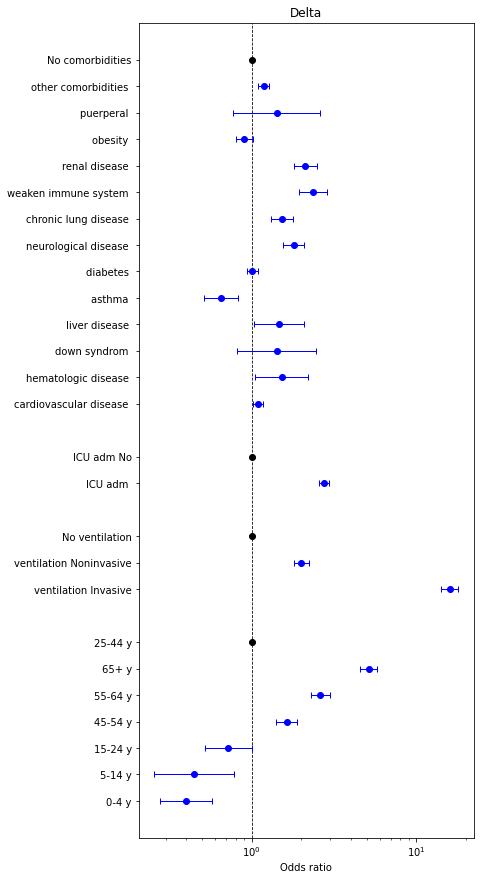

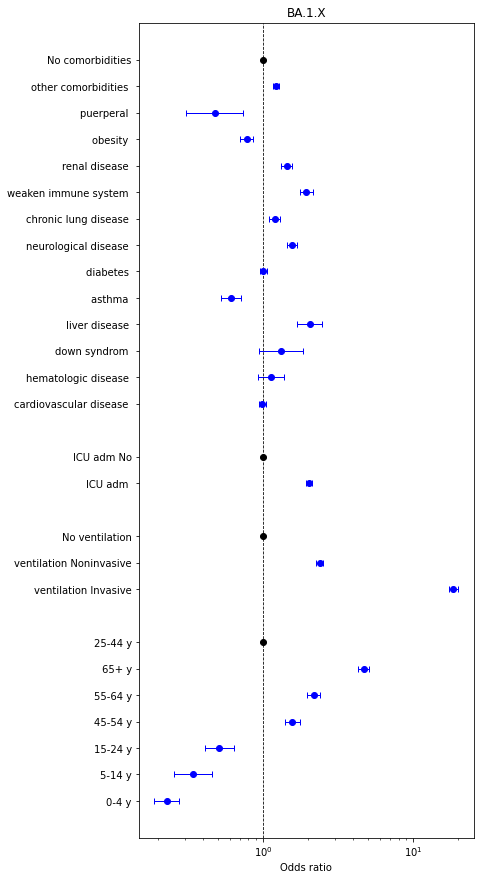

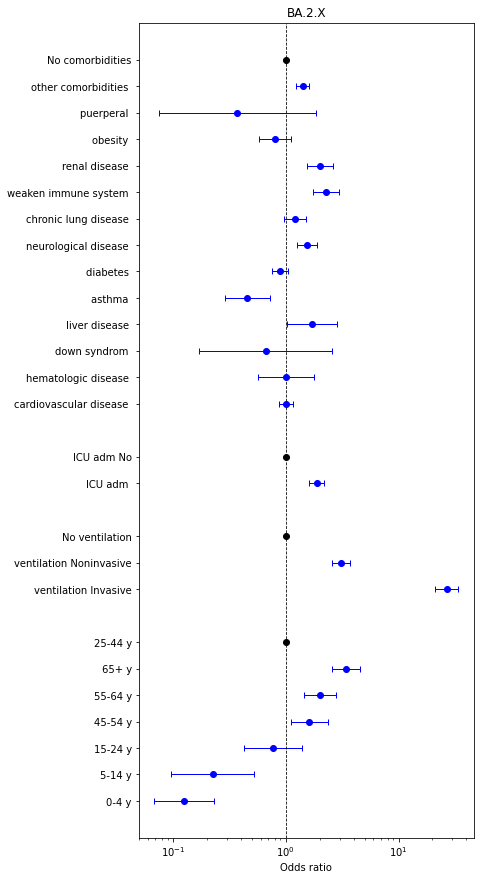

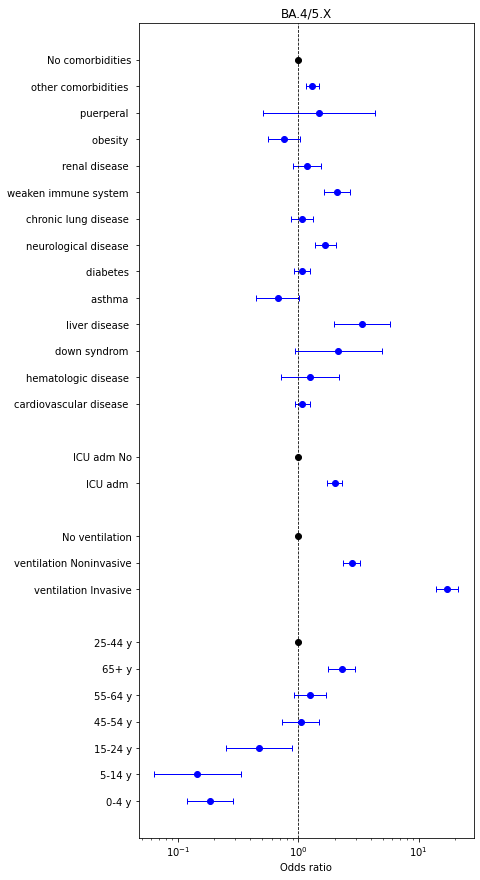

In [13]:
for variant in variants_name:
    plt.figure(figsize=(6,15))
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    list_yticks_y = []
    list_yticks_val = []
    list_param = data.columns[data.columns.str.contains(variant)].tolist()
    list_param.insert(0,'param')
    for param in univariate_parameters_withref:
        if param == 'comorbidities':
            loc_data = data[data.param.str.startswith(tuple(comorb_list))][list_param].copy()
        else:
            loc_data = data[data.param.str.startswith(param)][list_param].copy()
        if param == univariate_parameters_withref[0]:
            list_yticks_y.extend(loc_data['odds_ratio_'+variant].index.values.tolist())
            list_yticks_val.extend(loc_data.param.values.tolist())
        else:
            list_yticks_y.extend([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
            list_yticks_val.extend(loc_data.param.values.tolist())
        list_yticks_y.append(max(list_yticks_y)+1)
        list_yticks_val.append(references[univariate_parameters_withref.index(param)])
        #
        yticks_to_add = list_yticks_val.copy()
        for element in replace_label:
            yticks_to_add = [sub.replace(element[0],element[1]) for sub in yticks_to_add]
        list_yticks_val = yticks_to_add.copy()
        #
        if param == univariate_parameters_withref[0]:
            y_val = np.array(loc_data['odds_ratio_'+variant].index.values.tolist())
        else:
            y_val = np.array([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
        ci = [loc_data['odds_ratio_'+variant]-loc_data['CI_low_'+variant].values,loc_data['CI_high_'+variant].values-loc_data['odds_ratio_'+variant]]
        plt.errorbar(x=loc_data['odds_ratio_'+variant], y=y_val, xerr=ci, color='blue',  capsize=3, linestyle='None',
                     linewidth=1)
        if param == univariate_parameters_withref[0]:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko',label='Reference')
        else:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko')
    plt.yticks(list_yticks_y,list_yticks_val)
    plt.xlabel('Odds ratio')
    plt.title(variant)
    plt.show()    

### Multivariate logistic regression per variant: primary outcome
#### Dropping ICU and ventilation variables

In [14]:
univariate_parameters_withref = ['state','age_group','sex','ethnicity','nb_comorbidities','nb_vaccine_dose','icuadm',
                                 'ventilation','ventilation_outoficu','invasive_ventilation','delay_vaccine']
list_parameters_to_loop = univariate_parameters_withref.copy()
list_parameters_to_loop.remove('age_group') #parameter used in model as baseline
list_parameters_to_loop.remove('icuadm')
list_parameters_to_loop.remove('ventilation')
list_parameters_to_loop.remove('ventilation_outoficu')
list_parameters_to_loop.remove('invasive_ventilation')
list_parameters_to_loop.append('comorbidities') #variable used for all comorbidities grouped together
list_parameters_to_loop

['state',
 'sex',
 'ethnicity',
 'nb_comorbidities',
 'nb_vaccine_dose',
 'delay_vaccine',
 'comorbidities']

In [15]:
select_variables(0.01,df_analysis.variant.unique().tolist(),list_parameters_to_loop.copy(),'age_group_releveled','outcome')

outcome - Delta- Multivariate model: age_group_releveled+comorbidities+state_releveled

outcome - BA.1.X- Multivariate model: age_group_releveled+comorbidities+state_releveled

outcome - BA.2.X- Multivariate model: age_group_releveled+comorbidities+state_releveled

outcome - BA.4/5.X- Multivariate model: age_group_releveled+comorbidities+state_releveled



In [16]:
univariate_parameters_withref = ['age_group','state','comorbidities']
references = ['age_group 3','DF','No comorbidities']

In [17]:
df_regression = pd.DataFrame()
for variant in df_analysis.variant.unique():
    print(variant)
    variant_data = df_analysis[df_analysis.variant==variant].copy()
    variant_data = variant_data.reset_index(drop=True)
    reg = smf.logit('outcome ~ age_group_releveled + state_releveled + '+model_comorbidities,
                        data=variant_data).fit(method='ncg',disp=0)
    if variant == df_analysis.variant.unique()[0]:
        df_regression['param'] = reg.params.index[1:].str.replace('_releveled\[T.',' ').str.replace('\]','').str.replace('Yes','')
    df_regression['odds_ratio_'+variant] = np.exp(reg.params.values)[1:]
    conf = np.exp(reg.conf_int())[1:]
    conf.columns = ['CI_low','CI_high']
    df_regression['CI_low_'+variant] = conf.CI_low.values
    df_regression['CI_high_'+variant] = conf.CI_high.values
    df_regression['p_values_'+variant] = reg.pvalues.values[1:]
df_regression.to_csv('categorical_by_variant_withoutICUventil_multivariate.csv',index=False)

Delta
BA.1.X
BA.2.X
BA.4/5.X


In [18]:
data = df_regression

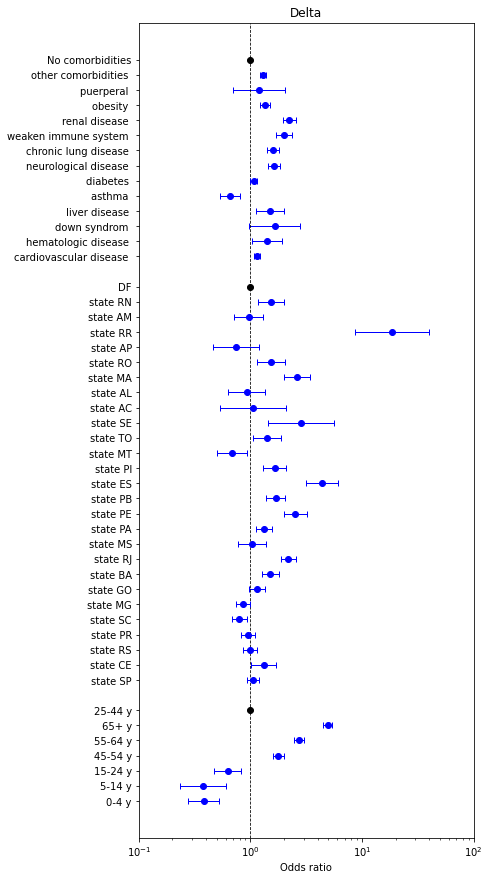

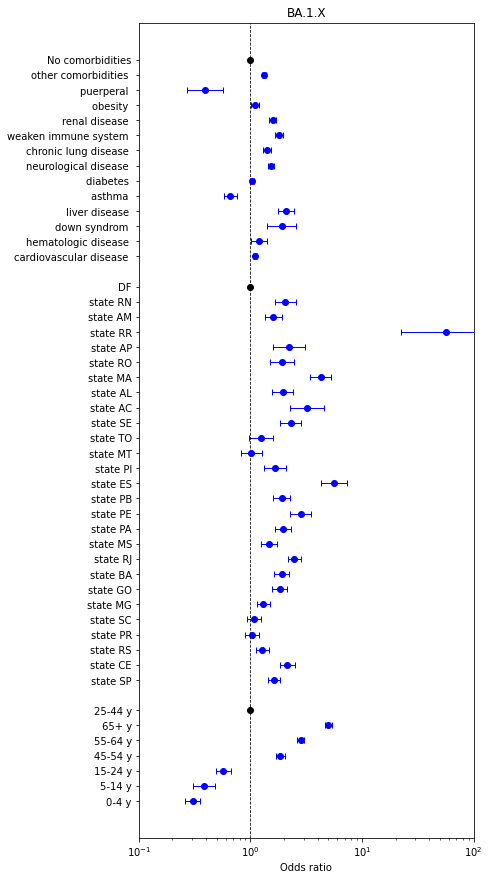

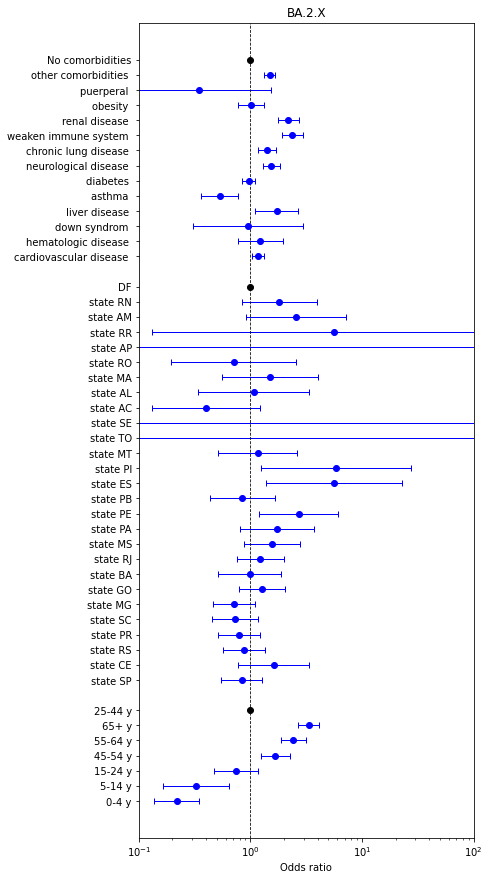

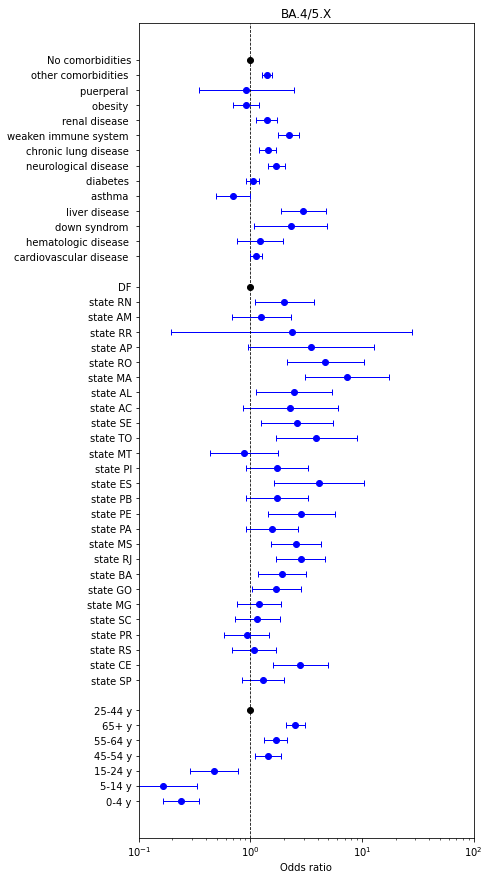

In [19]:
for variant in variants_name:
    plt.figure(figsize=(6,15))
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    list_yticks_y = []
    list_yticks_val = []
    list_param = data.columns[data.columns.str.contains(variant)].tolist()
    list_param.insert(0,'param')
    for param in univariate_parameters_withref:
        if param == 'comorbidities':
            loc_data = data[data.param.str.startswith(tuple(comorb_list))][list_param].copy()
        else:
            loc_data = data[data.param.str.startswith(param)][list_param].copy()
        if param == univariate_parameters_withref[0]:
            list_yticks_y.extend(loc_data['odds_ratio_'+variant].index.values.tolist())
            list_yticks_val.extend(loc_data.param.values.tolist())
        else:
            list_yticks_y.extend([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
            list_yticks_val.extend(loc_data.param.values.tolist())
        list_yticks_y.append(max(list_yticks_y)+1)
        list_yticks_val.append(references[univariate_parameters_withref.index(param)])
        #
        yticks_to_add = list_yticks_val.copy()
        for element in replace_label:
            yticks_to_add = [sub.replace(element[0],element[1]) for sub in yticks_to_add]
        list_yticks_val = yticks_to_add.copy()
        #
        if param == univariate_parameters_withref[0]:
            y_val = np.array(loc_data['odds_ratio_'+variant].index.values.tolist())
        else:
            y_val = np.array([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
        ci = [loc_data['odds_ratio_'+variant]-loc_data['CI_low_'+variant].values,loc_data['CI_high_'+variant].values-loc_data['odds_ratio_'+variant]]
        plt.errorbar(x=loc_data['odds_ratio_'+variant], y=y_val, xerr=ci, color='blue',  capsize=3, linestyle='None',
                     linewidth=1)
        if param == univariate_parameters_withref[0]:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko',label='Reference')
        else:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko')
    plt.yticks(list_yticks_y,list_yticks_val)
    plt.xlabel('Odds ratio')
#    print(plt.xlim(),plt.ylim())
    plt.axis([0.1,100,-2.45,51.45])
    plt.title(variant)
    plt.show()    

### Multivariate logistic regression per variant: number of vaccine dose impact on mortality

In [20]:
df_regression = pd.DataFrame()
for variant in df_analysis.variant.unique():
    print(variant)
    variant_data = df_analysis[df_analysis.variant==variant].copy()
    variant_data = variant_data.reset_index(drop=True)
    reg = smf.logit('outcome ~ age_group_releveled + ventilation_releveled + icuadm_releveled + '+model_comorbidities+' + nb_vaccine_dose_releveled',
                        data=variant_data).fit(method='ncg',disp=0)
    if variant == df_analysis.variant.unique()[0]:
        df_regression['param'] = reg.params.index[1:].str.replace('_releveled\[T.',' ').str.replace('\]','')
    df_regression['odds_ratio_'+variant] = np.exp(reg.params.values)[1:]
    conf = np.exp(reg.conf_int())[1:]
    conf.columns = ['CI_low','CI_high']
    df_regression['CI_low_'+variant] = conf.CI_low.values
    df_regression['CI_high_'+variant] = conf.CI_high.values
    df_regression['p_values_'+variant] = reg.pvalues.values[1:]

Delta
BA.1.X
BA.2.X
BA.4/5.X


In [21]:
data = df_regression
univariate_parameters_withref = ['age_group','ventilation','icuadm','comorbidities','nb_vaccine_dose']
references = ['age_group 3','No ventilation','icuadm No','No comorbidities','nb_vaccine_dose 0']

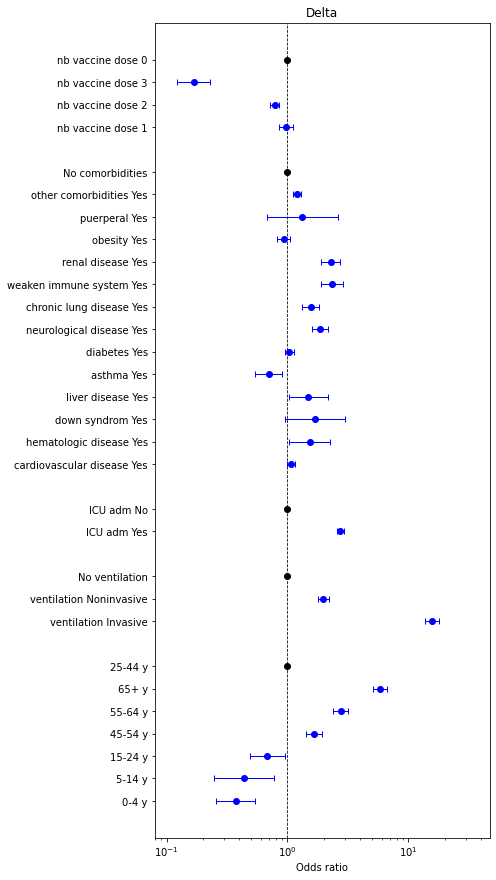

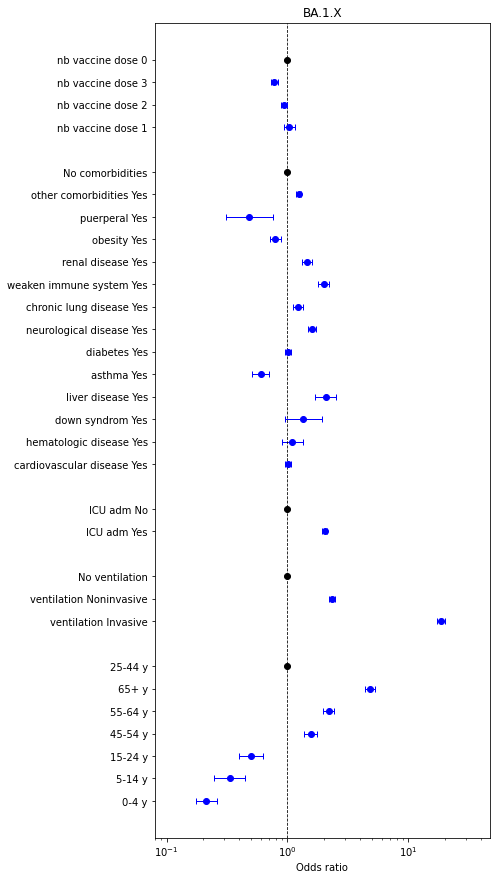

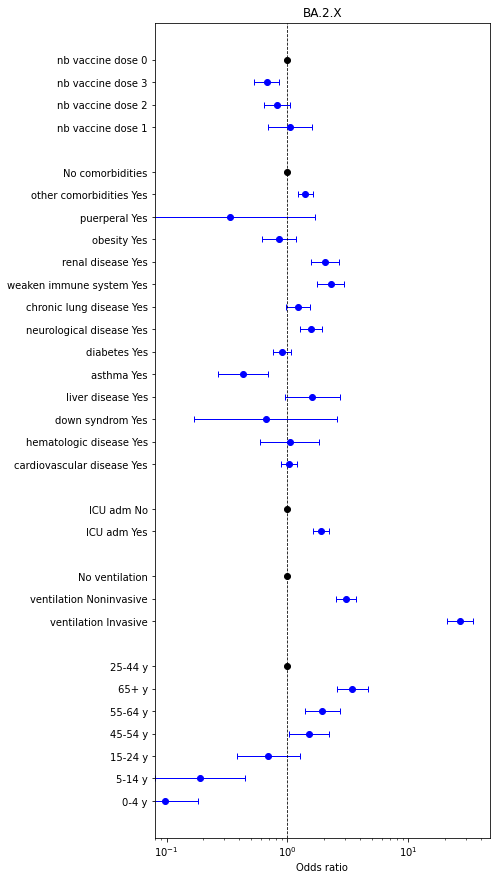

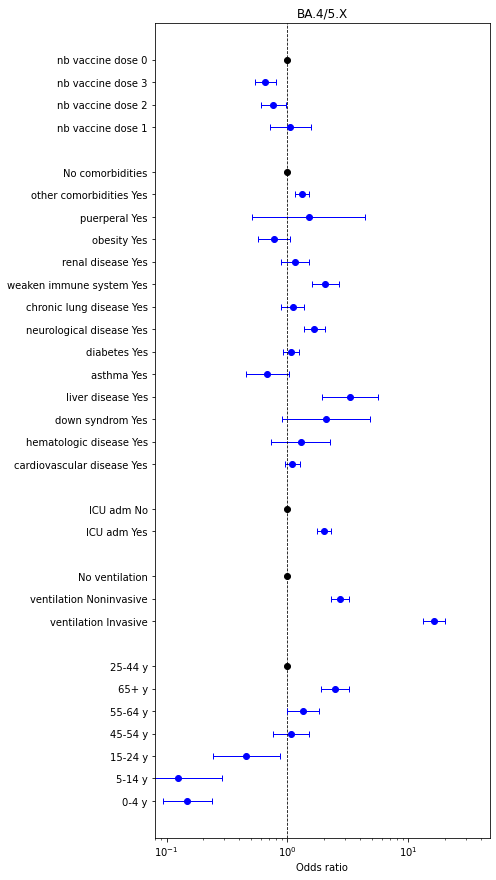

In [22]:
for variant in variants_name:
    plt.figure(figsize=(6,15))
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    list_yticks_y = []
    list_yticks_val = []
    list_param = data.columns[data.columns.str.contains(variant)].tolist()
    list_param.insert(0,'param')
    for param in univariate_parameters_withref:
        if param == 'comorbidities':
            loc_data = data[data.param.str.startswith(tuple(comorb_list))][list_param].copy()
        else:
            loc_data = data[data.param.str.startswith(param)][list_param].copy()
        if param == univariate_parameters_withref[0]:
            list_yticks_y.extend(loc_data['odds_ratio_'+variant].index.values.tolist())
            list_yticks_val.extend(loc_data.param.values.tolist())
        else:
            list_yticks_y.extend([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
            list_yticks_val.extend(loc_data.param.values.tolist())
        list_yticks_y.append(max(list_yticks_y)+1)
        list_yticks_val.append(references[univariate_parameters_withref.index(param)])
        #
        yticks_to_add = list_yticks_val.copy()
        for element in replace_label:
            yticks_to_add = [sub.replace(element[0],element[1]) for sub in yticks_to_add]
        list_yticks_val = yticks_to_add.copy()
        #
        if param == univariate_parameters_withref[0]:
            y_val = np.array(loc_data['odds_ratio_'+variant].index.values.tolist())
        else:
            y_val = np.array([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
        ci = [loc_data['odds_ratio_'+variant]-loc_data['CI_low_'+variant].values,loc_data['CI_high_'+variant].values-loc_data['odds_ratio_'+variant]]
        plt.errorbar(x=loc_data['odds_ratio_'+variant], y=y_val, xerr=ci, color='blue',  capsize=3, linestyle='None',
                     linewidth=1)
        if param == univariate_parameters_withref[0]:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko',label='Reference')
        else:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko')
    plt.yticks(list_yticks_y,list_yticks_val)
    plt.xlabel('Odds ratio')
#    print(plt.xlim(),plt.ylim())
    plt.axis([0.08,47,-1.65,34.65])
    plt.title(variant)
    plt.show()    

#### Dropping ICU and ventilation variables

In [23]:
df_regression = pd.DataFrame()
for variant in df_analysis.variant.unique():
    print(variant)
    variant_data = df_analysis[df_analysis.variant==variant].copy()
    variant_data = variant_data.reset_index(drop=True)
    reg = smf.logit('outcome ~ age_group_releveled + state_releveled + '+model_comorbidities+' + nb_vaccine_dose_releveled',
                        data=variant_data).fit(method='ncg',disp=0)
    if variant == df_analysis.variant.unique()[0]:
        df_regression['param'] = reg.params.index[1:].str.replace('_releveled\[T.',' ').str.replace('\]','')
    df_regression['odds_ratio_'+variant] = np.exp(reg.params.values)[1:]
    conf = np.exp(reg.conf_int())[1:]
    conf.columns = ['CI_low','CI_high']
    df_regression['CI_low_'+variant] = conf.CI_low.values
    df_regression['CI_high_'+variant] = conf.CI_high.values
    df_regression['p_values_'+variant] = reg.pvalues.values[1:]

Delta
BA.1.X
BA.2.X
BA.4/5.X


In [24]:
data = df_regression
univariate_parameters_withref = ['age_group','state','comorbidities','nb_vaccine_dose']
references = ['age_group 3','DF','No comorbidities','nb_vaccine_dose 0']

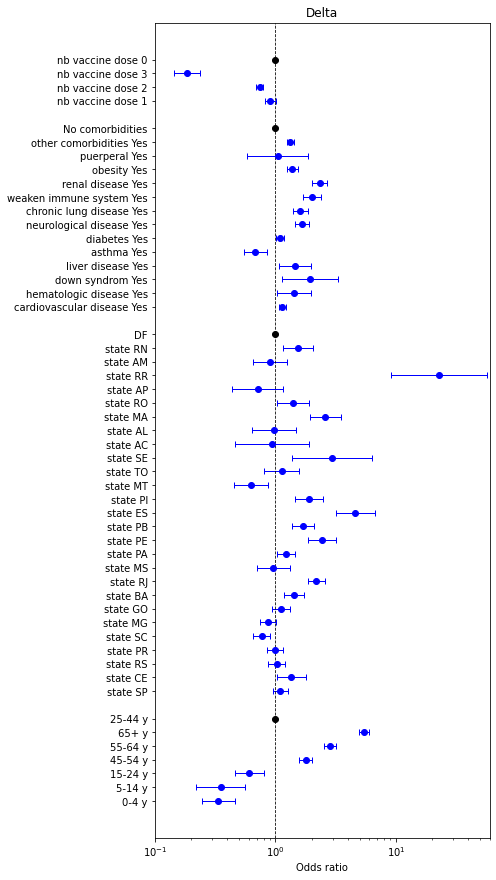

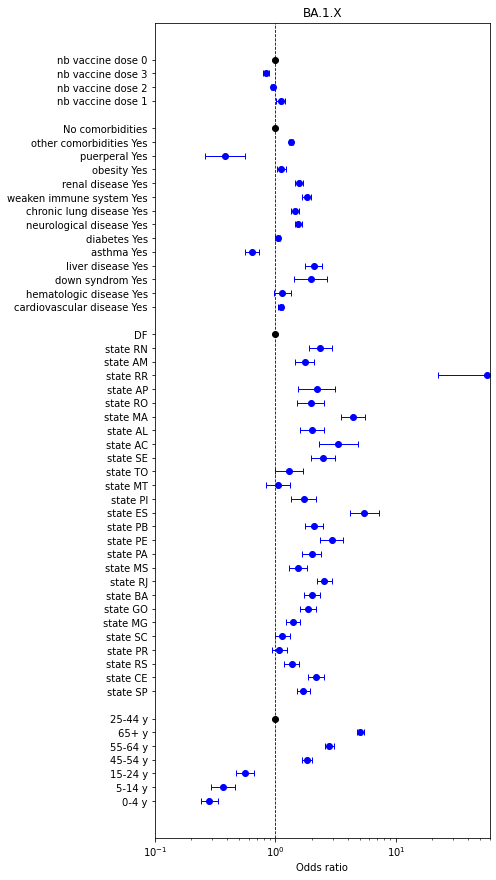

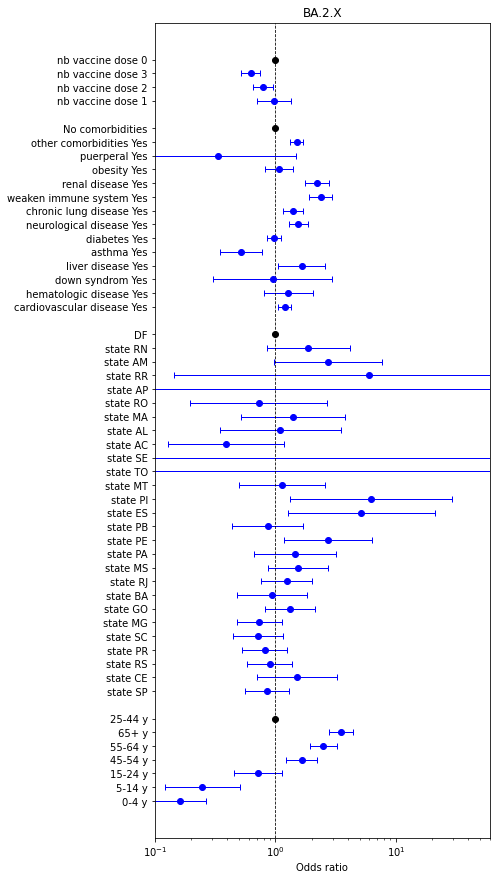

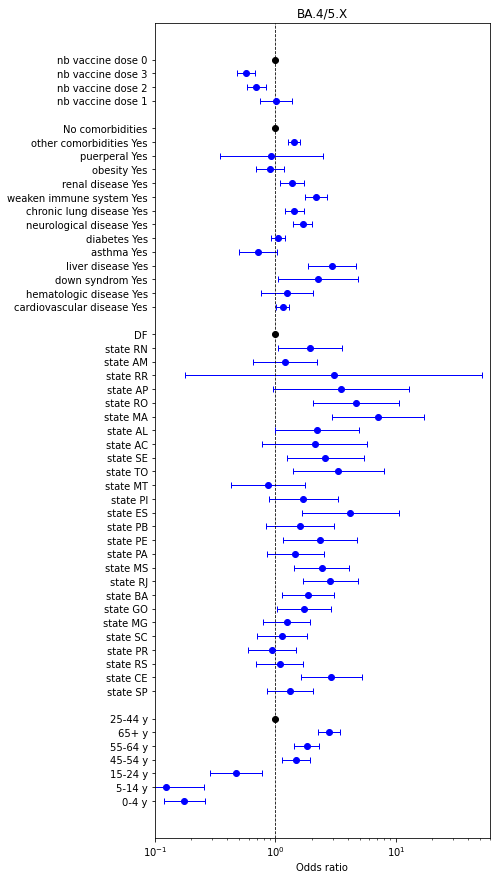

In [25]:
for variant in variants_name:
    plt.figure(figsize=(6,15))
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    list_yticks_y = []
    list_yticks_val = []
    list_param = data.columns[data.columns.str.contains(variant)].tolist()
    list_param.insert(0,'param')
    for param in univariate_parameters_withref:
        if param == 'comorbidities':
            loc_data = data[data.param.str.startswith(tuple(comorb_list))][list_param].copy()
        else:
            loc_data = data[data.param.str.startswith(param)][list_param].copy()
        if param == univariate_parameters_withref[0]:
            list_yticks_y.extend(loc_data['odds_ratio_'+variant].index.values.tolist())
            list_yticks_val.extend(loc_data.param.values.tolist())
        else:
            list_yticks_y.extend([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
            list_yticks_val.extend(loc_data.param.values.tolist())
        list_yticks_y.append(max(list_yticks_y)+1)
        list_yticks_val.append(references[univariate_parameters_withref.index(param)])
        #
        yticks_to_add = list_yticks_val.copy()
        for element in replace_label:
            yticks_to_add = [sub.replace(element[0],element[1]) for sub in yticks_to_add]
        list_yticks_val = yticks_to_add.copy()
        #
        if param == univariate_parameters_withref[0]:
            y_val = np.array(loc_data['odds_ratio_'+variant].index.values.tolist())
        else:
            y_val = np.array([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
        ci = [loc_data['odds_ratio_'+variant]-loc_data['CI_low_'+variant].values,loc_data['CI_high_'+variant].values-loc_data['odds_ratio_'+variant]]
        plt.errorbar(x=loc_data['odds_ratio_'+variant], y=y_val, xerr=ci, color='blue',  capsize=3, linestyle='None',
                     linewidth=1)
        if param == univariate_parameters_withref[0]:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko',label='Reference')
        else:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko')
    plt.yticks(list_yticks_y,list_yticks_val)
    plt.xlabel('Odds ratio')
#    print(plt.xlim(),plt.ylim())
    plt.axis([0.1,60,-2.7,56.7])
    plt.title(variant)
    plt.show()    

### Multivariate logistic regression per variant: secondary outcomes

- ICU admission
- Invasive ventilation

In [26]:
outcomes = ['ventilation_invasive','icu_adm']
outcome_delete_from_parameters = [['invasive_ventilation','ventilation','ventilation_outoficu'],
                                  ['icuadm','ventilation_outoficu','invasive_ventilation']]
univariate_parameters_withref = ['state','sex','ethnicity','nb_comorbidities','nb_vaccine_dose','icuadm',
                                 'ventilation','ventilation_outoficu','invasive_ventilation','delay_vaccine',
                                 'comorbidities']

In [27]:
for outcome in outcomes:
    local_parameters = univariate_parameters_withref.copy()
    if type(outcome_delete_from_parameters[outcomes.index(outcome)]) == list:
        for element in outcome_delete_from_parameters[outcomes.index(outcome)]:
            local_parameters.remove(element)
    else:
        local_parameters.remove(outcome_delete_from_parameters[outcomes.index(outcome)])
    select_variables(0.01,df_analysis.variant.unique().tolist(),local_parameters.copy(),'age_group_releveled',outcome)

ventilation_invasive - Delta- Multivariate model: age_group_releveled+icuadm_releveled+state_releveled+comorbidities

ventilation_invasive - BA.1.X- Multivariate model: age_group_releveled+icuadm_releveled+state_releveled+comorbidities

ventilation_invasive - BA.2.X- Multivariate model: age_group_releveled+icuadm_releveled+state_releveled+comorbidities+ethnicity_releveled

ventilation_invasive - BA.4/5.X- Multivariate model: age_group_releveled+icuadm_releveled+state_releveled+comorbidities+ethnicity_releveled

icu_adm - Delta- Multivariate model: age_group_releveled+ventilation_releveled+state_releveled

icu_adm - BA.1.X- Multivariate model: age_group_releveled+ventilation_releveled+state_releveled

icu_adm - BA.2.X- Multivariate model: age_group_releveled+ventilation_releveled+state_releveled+ethnicity_releveled

icu_adm - BA.4/5.X- Multivariate model: age_group_releveled+ventilation_releveled+state_releveled+ethnicity_releveled



- excluding ventilation for ICU / excluding ICU for ventilation

In [28]:
outcomes = ['ventilation_invasive','icu_adm']
outcome_delete_from_parameters = [['invasive_ventilation','ventilation','ventilation_outoficu','icuadm'],
                                  ['icuadm','ventilation_outoficu','invasive_ventilation','ventilation']]
univariate_parameters_withref = ['state','sex','ethnicity','nb_comorbidities','nb_vaccine_dose','icuadm',
                                 'ventilation','ventilation_outoficu','invasive_ventilation','delay_vaccine',
                                 'comorbidities']

In [29]:
for outcome in outcomes:
    local_parameters = univariate_parameters_withref.copy()
    if type(outcome_delete_from_parameters[outcomes.index(outcome)]) == list:
        for element in outcome_delete_from_parameters[outcomes.index(outcome)]:
            local_parameters.remove(element)
    else:
        local_parameters.remove(outcome_delete_from_parameters[outcomes.index(outcome)])
    select_variables(0.01,df_analysis.variant.unique().tolist(),local_parameters.copy(),'age_group_releveled',outcome)

ventilation_invasive - Delta- Multivariate model: age_group_releveled+state_releveled+nb_comorbidities_releveled

ventilation_invasive - BA.1.X- Multivariate model: age_group_releveled+state_releveled+nb_comorbidities_releveled

ventilation_invasive - BA.2.X- Multivariate model: age_group_releveled+state_releveled+nb_comorbidities_releveled

ventilation_invasive - BA.4/5.X- Multivariate model: age_group_releveled+state_releveled+nb_comorbidities_releveled

icu_adm - Delta- Multivariate model: age_group_releveled+state_releveled

icu_adm - BA.1.X- Multivariate model: age_group_releveled+state_releveled



C:\Users\stde\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


icu_adm - BA.2.X- Multivariate model: age_group_releveled+state_releveled

icu_adm - BA.4/5.X- Multivariate model: age_group_releveled+state_releveled+nb_comorbidities_releveled



#### Final model for ICU admission

In [30]:
model_by_variant = ['age_group_releveled+ventilation_releveled+state_releveled',
                    'age_group_releveled+ventilation_releveled+state_releveled',
                    'age_group_releveled+ventilation_releveled+state_releveled+ethnicity_releveled',
                    'age_group_releveled+ventilation_releveled+state_releveled+ethnicity_releveled']
univariate_parameters_withref_list = [['age_group','ventilation','state'],['age_group','ventilation','state'],
                                      ['age_group','ventilation','state','ethnicity'],['age_group','ventilation','state','ethnicity']]
references_list = [['age_group 3','No ventilation','DF'],['age_group 3','No ventilation','DF'],
                   ['age_group 3','No ventilation','DF','white'],['age_group 3','No ventilation','DF','white']]
axis_lim_list = [[0.3,50,-2,40],[0.1,40,-2,40],[0.1,50,-2.2,46.2],[0.01,50,-2.2,46.2]]

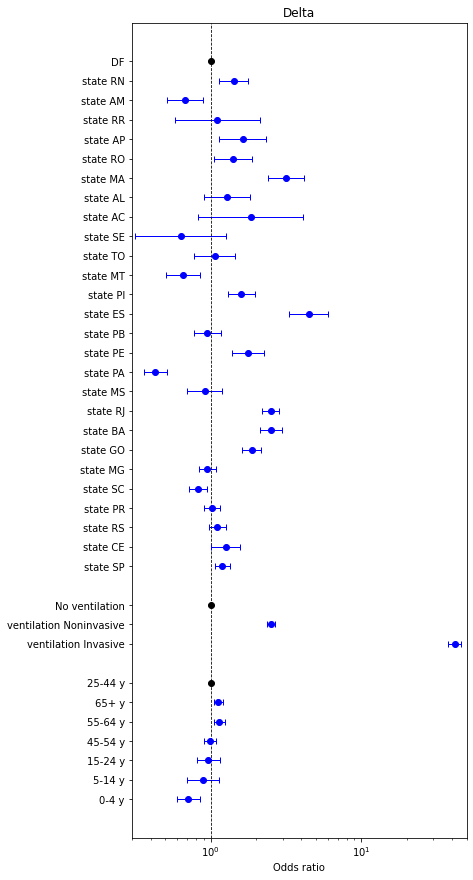

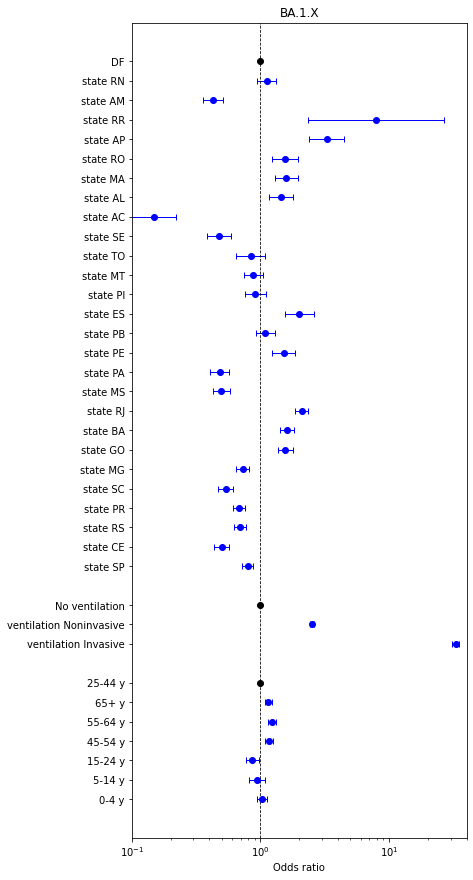

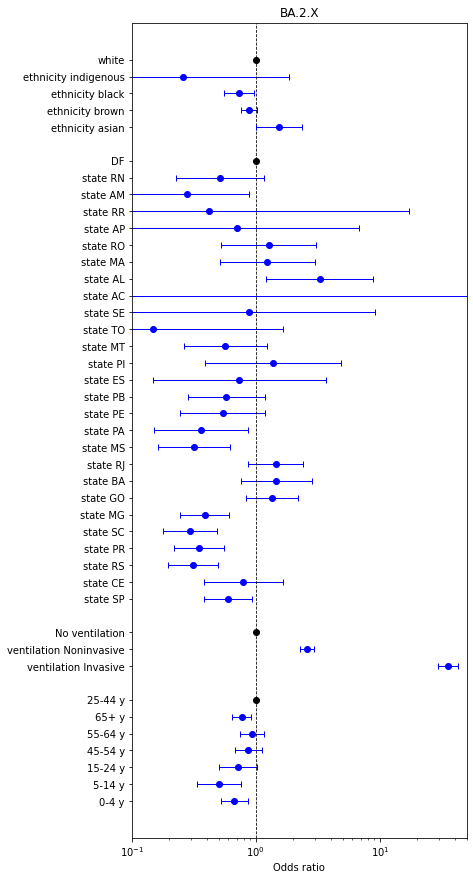

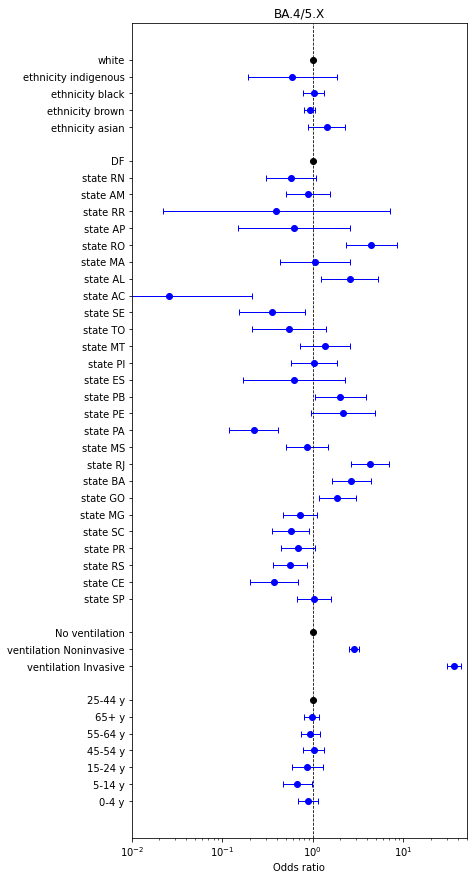

In [31]:
for variant in variants_name:
    #dataframe with data
    df_regression = pd.DataFrame()
    variant_data = df_analysis[df_analysis.variant==variant].copy()
    variant_data = variant_data.reset_index(drop=True)
    reg = smf.logit('icu_adm ~ '+model_by_variant[variants_name.index(variant)],
                        data=variant_data).fit(disp=0,method='ncg')
    df_regression['param'] = reg.params.index[1:].str.replace('_releveled\[T.',' ').str.replace('\]','')
    df_regression['odds_ratio_'+variant] = np.exp(reg.params.values)[1:]
    conf = np.exp(reg.conf_int())[1:]
    conf.columns = ['CI_low','CI_high']
    df_regression['CI_low_'+variant] = conf.CI_low.values
    df_regression['CI_high_'+variant] = conf.CI_high.values
    df_regression['p_values_'+variant] = reg.pvalues.values[1:]
    df_regression.to_csv('icu_adm_categorical_'+file_name[variants_name.index(variant)]+'_multivariate.csv',index=False)
    #
    data = df_regression.copy()
    univariate_parameters_withref = univariate_parameters_withref_list[variants_name.index(variant)]
    references = references_list[variants_name.index(variant)]
    #figure
    plt.figure(figsize=(6,15))
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    list_yticks_y = []
    list_yticks_val = []
    list_param = data.columns[data.columns.str.contains(variant)].tolist()
    list_param.insert(0,'param')
    for param in univariate_parameters_withref:
        loc_data = data[data.param.str.startswith(param)][list_param].copy()
        if param == univariate_parameters_withref[0]:
            list_yticks_y.extend(loc_data['odds_ratio_'+variant].index.values.tolist())
            list_yticks_val.extend(loc_data.param.values.tolist())
        else:
            list_yticks_y.extend([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
            list_yticks_val.extend(loc_data.param.values.tolist())
        list_yticks_y.append(max(list_yticks_y)+1)
        list_yticks_val.append(references[univariate_parameters_withref.index(param)])
        #
        yticks_to_add = list_yticks_val.copy()
        for element in replace_label:
            yticks_to_add = [sub.replace(element[0],element[1]) for sub in yticks_to_add]
        list_yticks_val = yticks_to_add.copy()
        #
        if param == univariate_parameters_withref[0]:
            y_val = np.array(loc_data['odds_ratio_'+variant].index.values.tolist())
        else:
            y_val = np.array([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
        ci = [loc_data['odds_ratio_'+variant]-loc_data['CI_low_'+variant].values,loc_data['CI_high_'+variant].values-loc_data['odds_ratio_'+variant]]
        plt.errorbar(x=loc_data['odds_ratio_'+variant], y=y_val, xerr=ci, color='blue',  capsize=3, linestyle='None',
                     linewidth=1)
        if param == univariate_parameters_withref[0]:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko',label='Reference')
        else:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko')
    plt.yticks(list_yticks_y,list_yticks_val)
    plt.xlabel('Odds ratio')
#    print(plt.xlim(),plt.ylim())
    plt.axis(axis_lim_list[variants_name.index(variant)])
    plt.title(variant)
    plt.show()    

#### Final model for ICU admission: dropping ventilation

In [32]:
model_by_variant = ['age_group_releveled+state_releveled',
                    'age_group_releveled+state_releveled',
                    'age_group_releveled+state_releveled',
                    'age_group_releveled+state_releveled+nb_comorbidities_releveled']
univariate_parameters_withref_list = [['age_group','state'],['age_group','state'],
                                      ['age_group','state'],['age_group','state','nb_comorbidities']]
references_list = [['age_group 3','DF'],['age_group 3','DF'],
                   ['age_group 3','DF'],['age_group 3','DF','nb_comorbidities 0']]
axis_lim_list = [[0.3,9,-1.7,35.7],[0.2,30,-1.7,35.7],[0.3,10,-1.7,35.],[0.3,10,-2,42]]

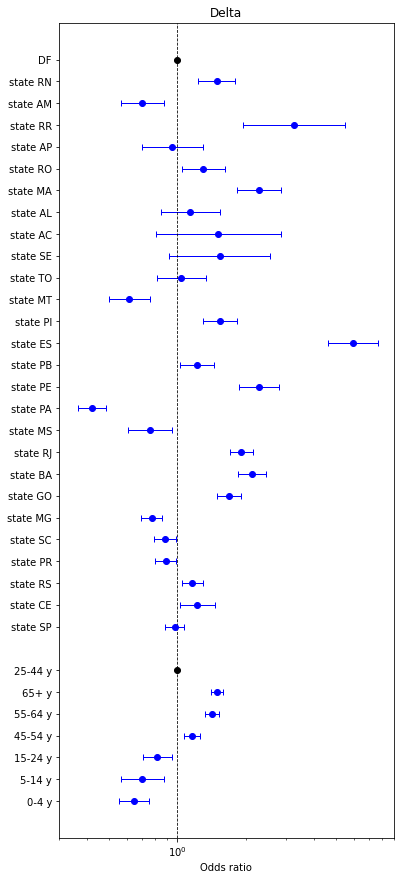

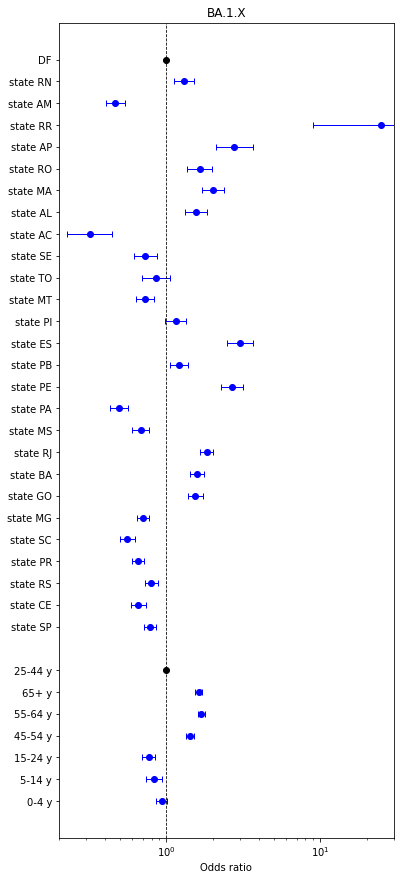

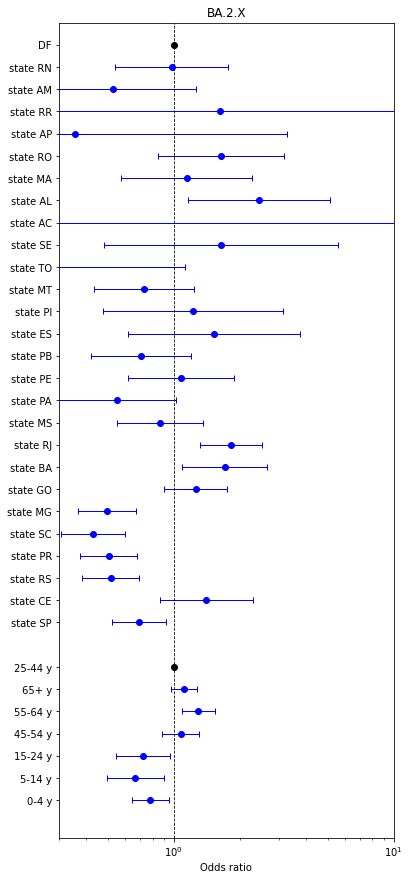

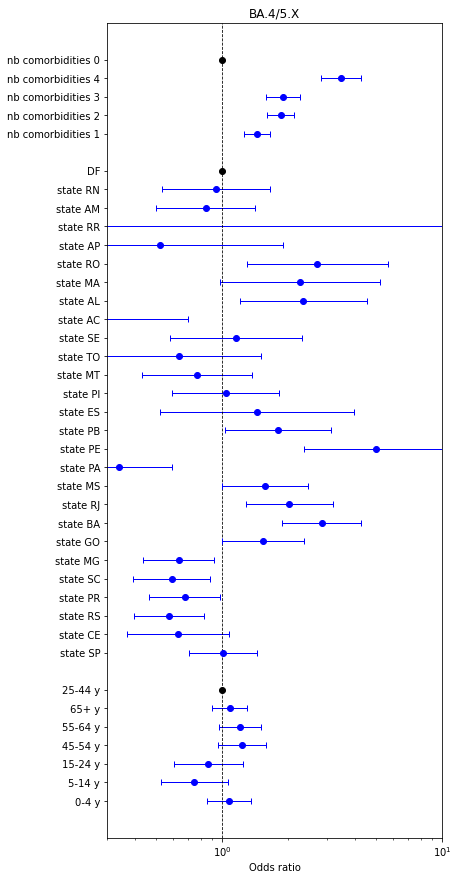

In [33]:
for variant in variants_name:
    #dataframe with data
    df_regression = pd.DataFrame()
    variant_data = df_analysis[df_analysis.variant==variant].copy()
    variant_data = variant_data.reset_index(drop=True)
    reg = smf.logit('icu_adm ~ '+model_by_variant[variants_name.index(variant)],
                        data=variant_data).fit(disp=0,method='ncg')
    df_regression['param'] = reg.params.index[1:].str.replace('_releveled\[T.',' ').str.replace('\]','')
    df_regression['odds_ratio_'+variant] = np.exp(reg.params.values)[1:]
    conf = np.exp(reg.conf_int())[1:]
    conf.columns = ['CI_low','CI_high']
    df_regression['CI_low_'+variant] = conf.CI_low.values
    df_regression['CI_high_'+variant] = conf.CI_high.values
    df_regression['p_values_'+variant] = reg.pvalues.values[1:]
    df_regression.to_csv('icu_adm_categorical_'+file_name[variants_name.index(variant)]+'_multivariate.csv',index=False)
    #
    data = df_regression.copy()
    univariate_parameters_withref = univariate_parameters_withref_list[variants_name.index(variant)]
    references = references_list[variants_name.index(variant)]
    #figure
    plt.figure(figsize=(6,15))
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    list_yticks_y = []
    list_yticks_val = []
    list_param = data.columns[data.columns.str.contains(variant)].tolist()
    list_param.insert(0,'param')
    for param in univariate_parameters_withref:
        loc_data = data[data.param.str.startswith(param)][list_param].copy()
        if param == univariate_parameters_withref[0]:
            list_yticks_y.extend(loc_data['odds_ratio_'+variant].index.values.tolist())
            list_yticks_val.extend(loc_data.param.values.tolist())
        else:
            list_yticks_y.extend([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
            list_yticks_val.extend(loc_data.param.values.tolist())
        list_yticks_y.append(max(list_yticks_y)+1)
        list_yticks_val.append(references[univariate_parameters_withref.index(param)])
        #
        yticks_to_add = list_yticks_val.copy()
        for element in replace_label:
            yticks_to_add = [sub.replace(element[0],element[1]) for sub in yticks_to_add]
        list_yticks_val = yticks_to_add.copy()
        #
        if param == univariate_parameters_withref[0]:
            y_val = np.array(loc_data['odds_ratio_'+variant].index.values.tolist())
        else:
            y_val = np.array([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
        ci = [loc_data['odds_ratio_'+variant]-loc_data['CI_low_'+variant].values,loc_data['CI_high_'+variant].values-loc_data['odds_ratio_'+variant]]
        plt.errorbar(x=loc_data['odds_ratio_'+variant], y=y_val, xerr=ci, color='blue',  capsize=3, linestyle='None',
                     linewidth=1)
        if param == univariate_parameters_withref[0]:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko',label='Reference')
        else:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko')
    plt.yticks(list_yticks_y,list_yticks_val)
    plt.xlabel('Odds ratio')
#    print(plt.xlim(),plt.ylim())
    plt.axis(axis_lim_list[variants_name.index(variant)])
    plt.title(variant)
    plt.show()    

#### Final model for ventilation

In [34]:
model_by_variant = ['age_group_releveled+icuadm_releveled+state_releveled+'+model_comorbidities,
                    'age_group_releveled+icuadm_releveled+state_releveled+'+model_comorbidities,
                    'age_group_releveled+icuadm_releveled+state_releveled+'+model_comorbidities+'+ethnicity_releveled',
                    'age_group_releveled+icuadm_releveled+state_releveled+'+model_comorbidities+'+ethnicity_releveled']
univariate_parameters_withref_list = [['age_group','icuadm','state','comorbidities'],
                                      ['age_group','icuadm','state','comorbidities'],
                                      ['age_group','icuadm','state','comorbidities','ethnicity'],
                                      ['age_group','icuadm','state','comorbidities','ethnicity']]
references_list = [['age_group 3','icuadm No','DF','No comorbidities'],['age_group 3','icuadm No','DF','No comorbidities'],
                   ['age_group 3','icuadm No','DF','No comorbidities','white'],
                   ['age_group 3','icuadm No','DF','No comorbidities','white']]
axis_lim_list = [[0.3,30,-2.6,54.6],[0.5,20,-2.6,54.6],[0.1,130,-2.9,60.9],[0.1,30,-2.9,60.9]]

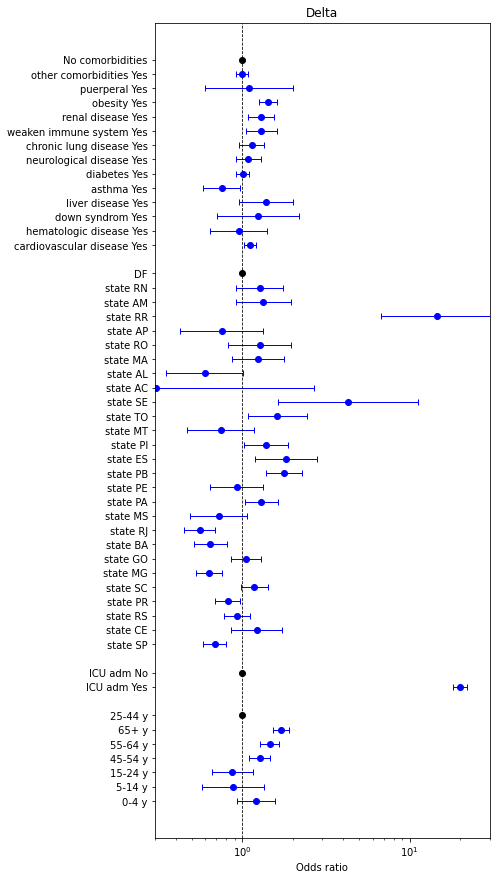

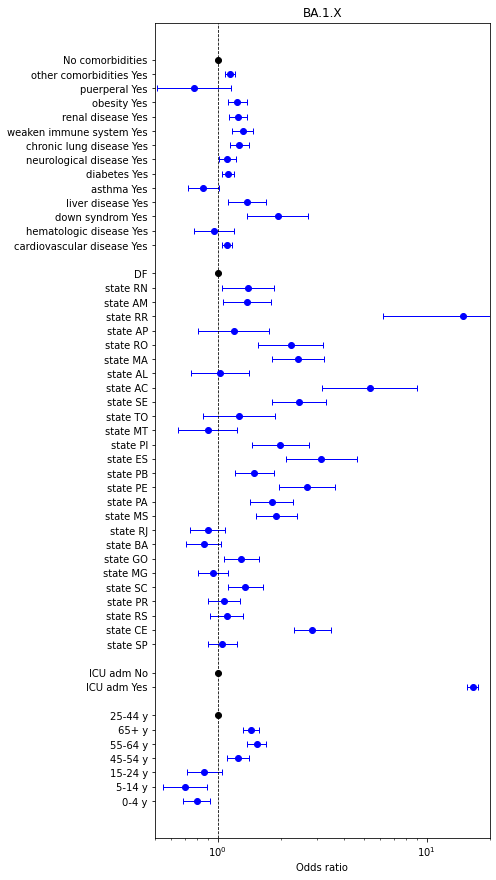

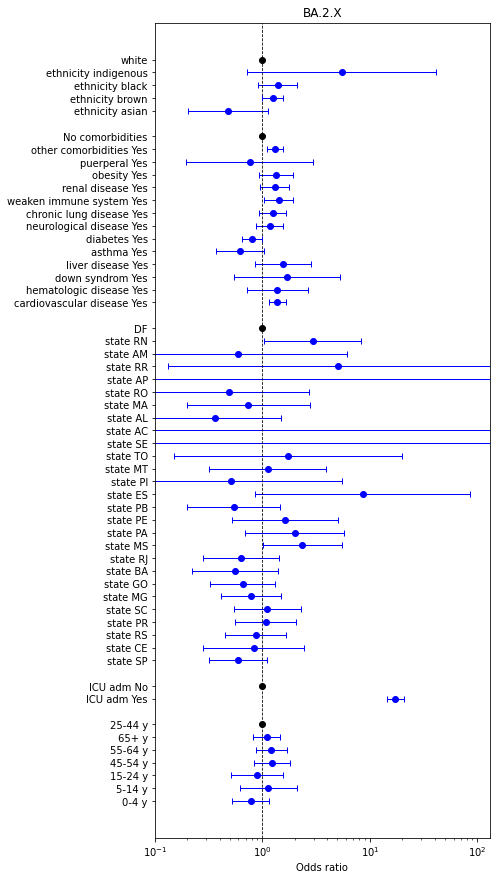

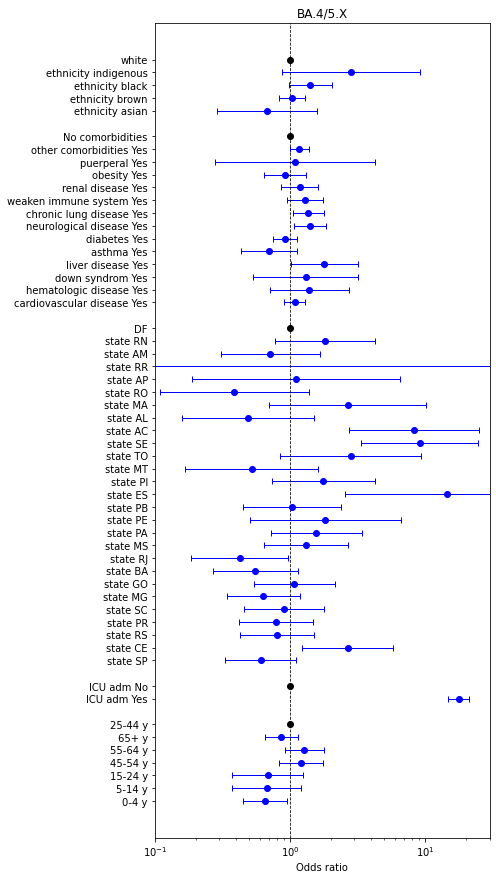

In [35]:
for variant in variants_name:
    #dataframe with data
    df_regression = pd.DataFrame()
    variant_data = df_analysis[df_analysis.variant==variant].copy()
    variant_data = variant_data.reset_index(drop=True)
    reg = smf.logit('ventilation_invasive ~ '+model_by_variant[variants_name.index(variant)],
                        data=variant_data).fit(disp=0,method='ncg')
    df_regression['param'] = reg.params.index[1:].str.replace('_releveled\[T.',' ').str.replace('\]','')
    df_regression['odds_ratio_'+variant] = np.exp(reg.params.values)[1:]
    conf = np.exp(reg.conf_int())[1:]
    conf.columns = ['CI_low','CI_high']
    df_regression['CI_low_'+variant] = conf.CI_low.values
    df_regression['CI_high_'+variant] = conf.CI_high.values
    df_regression['p_values_'+variant] = reg.pvalues.values[1:]
    df_regression.to_csv('ventilation_categorical_'+file_name[variants_name.index(variant)]+'_multivariate.csv',index=False)
    #
    data = df_regression.copy()
    univariate_parameters_withref = univariate_parameters_withref_list[variants_name.index(variant)]
    references = references_list[variants_name.index(variant)]
    #figure
    plt.figure(figsize=(6,15))
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    list_yticks_y = []
    list_yticks_val = []
    list_param = data.columns[data.columns.str.contains(variant)].tolist()
    list_param.insert(0,'param')
    for param in univariate_parameters_withref:
        if param == 'comorbidities':
            loc_data = data[data.param.str.startswith(tuple(comorb_list))][list_param].copy()
        else:
            loc_data = data[data.param.str.startswith(param)][list_param].copy()
        if param == univariate_parameters_withref[0]:
            list_yticks_y.extend(loc_data['odds_ratio_'+variant].index.values.tolist())
            list_yticks_val.extend(loc_data.param.values.tolist())
        else:
            list_yticks_y.extend([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
            list_yticks_val.extend(loc_data.param.values.tolist())
        list_yticks_y.append(max(list_yticks_y)+1)
        list_yticks_val.append(references[univariate_parameters_withref.index(param)])
        #
        yticks_to_add = list_yticks_val.copy()
        for element in replace_label:
            yticks_to_add = [sub.replace(element[0],element[1]) for sub in yticks_to_add]
        list_yticks_val = yticks_to_add.copy()
        #
        if param == univariate_parameters_withref[0]:
            y_val = np.array(loc_data['odds_ratio_'+variant].index.values.tolist())
        else:
            y_val = np.array([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
        ci = [loc_data['odds_ratio_'+variant]-loc_data['CI_low_'+variant].values,loc_data['CI_high_'+variant].values-loc_data['odds_ratio_'+variant]]
        plt.errorbar(x=loc_data['odds_ratio_'+variant], y=y_val, xerr=ci, color='blue',  capsize=3, linestyle='None',
                     linewidth=1)
        if param == univariate_parameters_withref[0]:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko',label='Reference')
        else:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko')
    plt.yticks(list_yticks_y,list_yticks_val)
    plt.xlabel('Odds ratio')
#    print(plt.xlim(),plt.ylim())
    plt.axis(axis_lim_list[variants_name.index(variant)])
    plt.title(variant)
    plt.show()    

#### Final model for ventilation: dropping ICU

In [36]:
model_by_variant = ['age_group_releveled+state_releveled+nb_comorbidities_releveled',
                    'age_group_releveled+state_releveled+nb_comorbidities_releveled',
                    'age_group_releveled+state_releveled+nb_comorbidities_releveled',
                    'age_group_releveled+state_releveled+nb_comorbidities_releveled']
univariate_parameters_withref_list = [['age_group','state','nb_comorbidities'],
                                      ['age_group','state','nb_comorbidities'],
                                      ['age_group','state','nb_comorbidities'],
                                      ['age_group','state','nb_comorbidities']]
references_list = [['age_group 3','DF','nb_comorbidities 0'],['age_group 3','DF','nb_comorbidities 0'],
                   ['age_group 3','DF','nb_comorbidities 0'],
                   ['age_group 3','DF','nb_comorbidities 0']]
axis_lim_list = [[0.3,20,-2,42],[0.5,100,-2,42],[0.1,100,-2,42],[0.1,100,-2,42]]

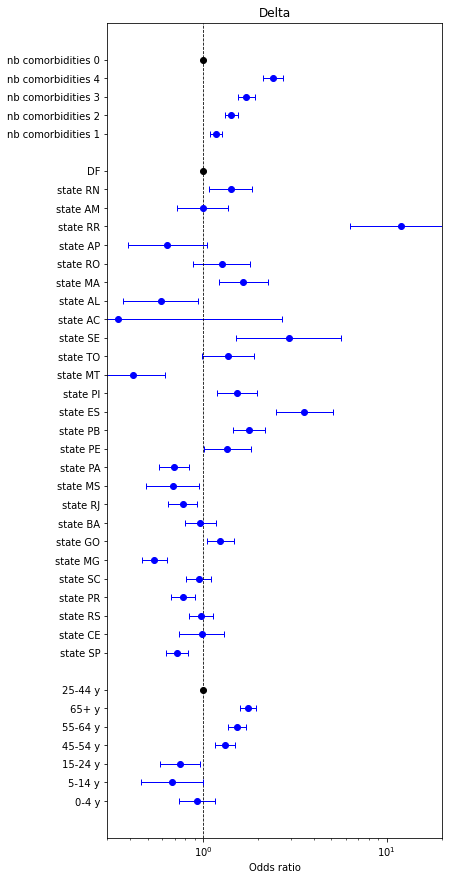

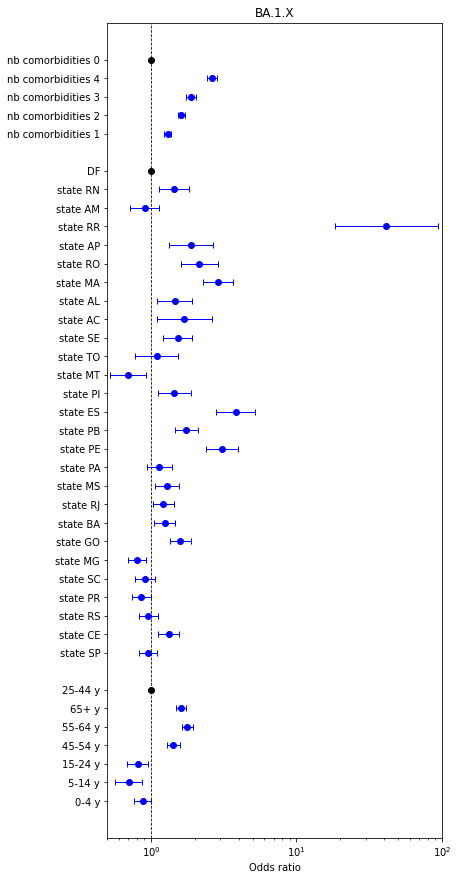

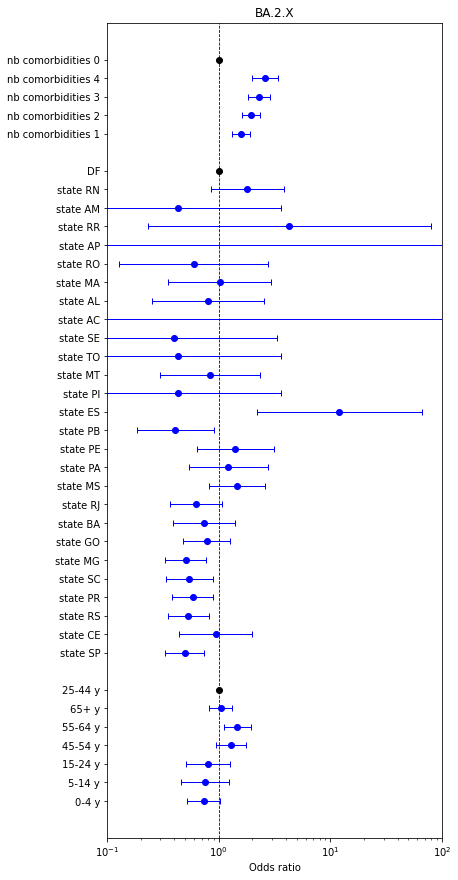

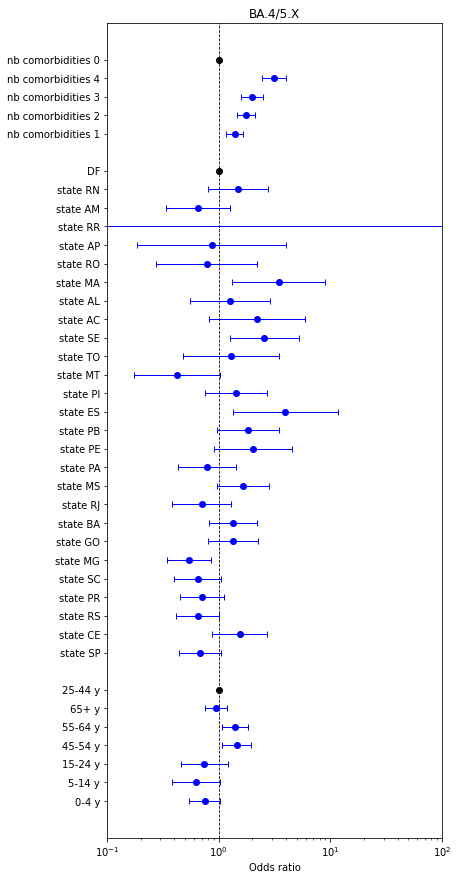

In [37]:
for variant in variants_name:
    #dataframe with data
    df_regression = pd.DataFrame()
    variant_data = df_analysis[df_analysis.variant==variant].copy()
    variant_data = variant_data.reset_index(drop=True)
    reg = smf.logit('ventilation_invasive ~ '+model_by_variant[variants_name.index(variant)],
                        data=variant_data).fit(disp=0,method='ncg')
    df_regression['param'] = reg.params.index[1:].str.replace('_releveled\[T.',' ').str.replace('\]','')
    df_regression['odds_ratio_'+variant] = np.exp(reg.params.values)[1:]
    conf = np.exp(reg.conf_int())[1:]
    conf.columns = ['CI_low','CI_high']
    df_regression['CI_low_'+variant] = conf.CI_low.values
    df_regression['CI_high_'+variant] = conf.CI_high.values
    df_regression['p_values_'+variant] = reg.pvalues.values[1:]
    df_regression.to_csv('ventilation_categorical_'+file_name[variants_name.index(variant)]+'_multivariate.csv',index=False)
    #
    data = df_regression.copy()
    univariate_parameters_withref = univariate_parameters_withref_list[variants_name.index(variant)]
    references = references_list[variants_name.index(variant)]
    #figure
    plt.figure(figsize=(6,15))
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    list_yticks_y = []
    list_yticks_val = []
    list_param = data.columns[data.columns.str.contains(variant)].tolist()
    list_param.insert(0,'param')
    for param in univariate_parameters_withref:
        if param == 'comorbidities':
            loc_data = data[data.param.str.startswith(tuple(comorb_list))][list_param].copy()
        else:
            loc_data = data[data.param.str.startswith(param)][list_param].copy()
        if param == univariate_parameters_withref[0]:
            list_yticks_y.extend(loc_data['odds_ratio_'+variant].index.values.tolist())
            list_yticks_val.extend(loc_data.param.values.tolist())
        else:
            list_yticks_y.extend([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
            list_yticks_val.extend(loc_data.param.values.tolist())
        list_yticks_y.append(max(list_yticks_y)+1)
        list_yticks_val.append(references[univariate_parameters_withref.index(param)])
        #
        yticks_to_add = list_yticks_val.copy()
        for element in replace_label:
            yticks_to_add = [sub.replace(element[0],element[1]) for sub in yticks_to_add]
        list_yticks_val = yticks_to_add.copy()
        #
        if param == univariate_parameters_withref[0]:
            y_val = np.array(loc_data['odds_ratio_'+variant].index.values.tolist())
        else:
            y_val = np.array([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
        ci = [loc_data['odds_ratio_'+variant]-loc_data['CI_low_'+variant].values,loc_data['CI_high_'+variant].values-loc_data['odds_ratio_'+variant]]
        plt.errorbar(x=loc_data['odds_ratio_'+variant], y=y_val, xerr=ci, color='blue',  capsize=3, linestyle='None',
                     linewidth=1)
        if param == univariate_parameters_withref[0]:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko',label='Reference')
        else:
            plt.semilogx(loc_data['odds_ratio_'+variant],y_val,'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko')
    plt.yticks(list_yticks_y,list_yticks_val)
    plt.xlabel('Odds ratio')
#    print(plt.xlim(),plt.ylim())
    plt.axis(axis_lim_list[variants_name.index(variant)])
    plt.title(variant)
    plt.show()    